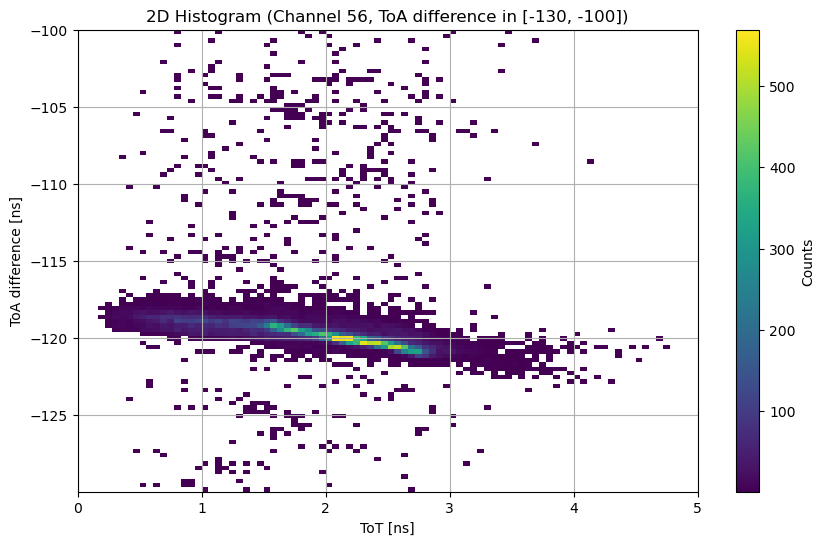

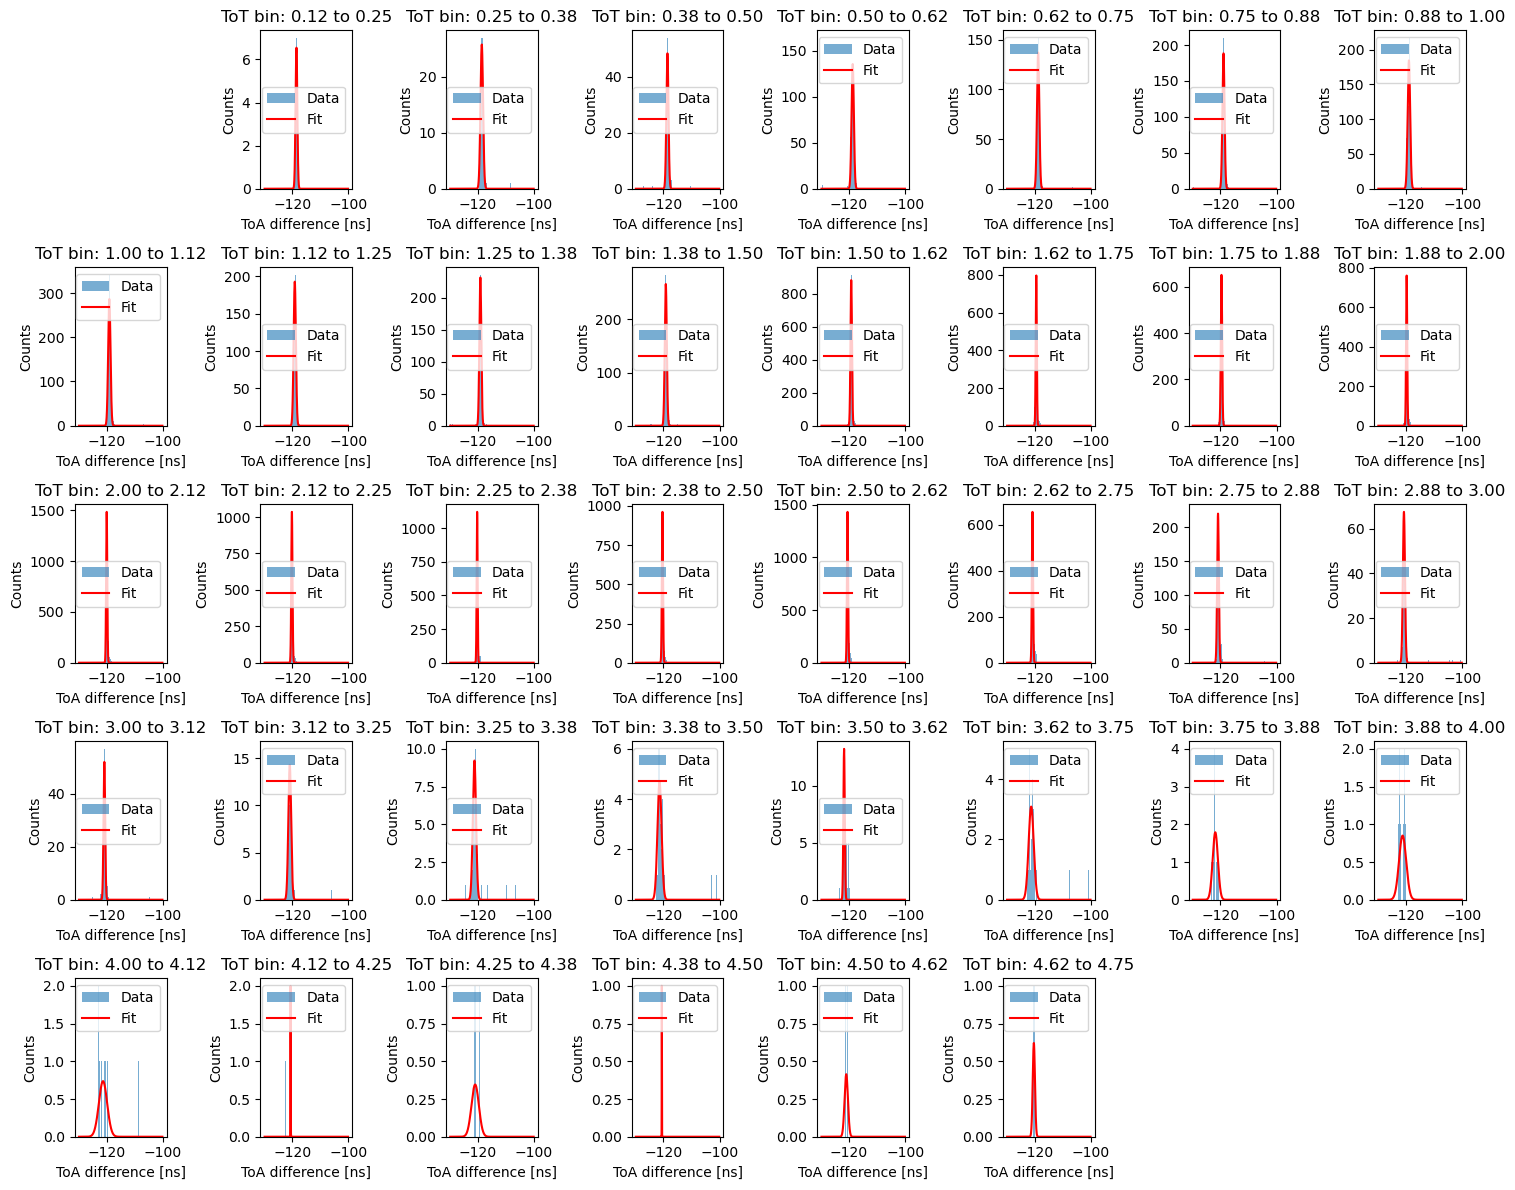

Predicted fit value for ToT = 3: -121.03276818419886


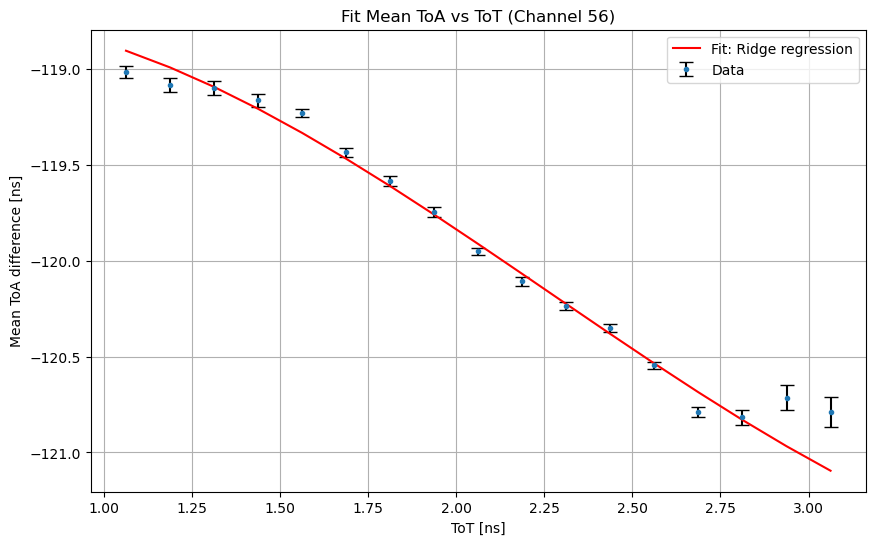

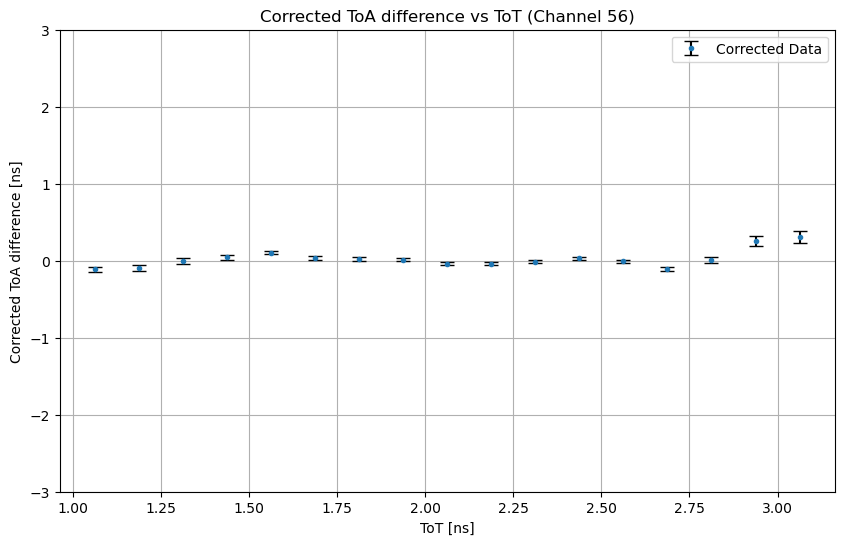

Fitted Polynomial Equation:
y = -118.9866 + (0.9509)*ToT + (-0.9748)*ToT^2 + (0.1435)*ToT^3


In [94]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.optimize import curve_fit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'time_difference_plots_tref_ch7_fullTDC_LAPPD_bottom_run0419.root'
channel = 56
hist_name_template = 'ToA_ToT_intime_ch{0};1'
hist_name = hist_name_template.format(channel)

w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

# Set the y range here
y_min = -130
y_max = -100

y_indices = np.where((ToA_edges >= y_min) & (ToA_edges <= y_max))[0]

if ToA_edges[y_indices[-1]] > y_max:
    y_indices = y_indices[:-1]

w_sliced = w[:, y_indices[:-1]]
ToA_edges_sliced = ToA_edges[y_indices]

cmap = plt.cm.viridis
cmap.set_under(color='white')

plt.figure(figsize=(10, 6))
plt.pcolormesh(ToT_edges, ToA_edges_sliced, w_sliced.T, shading='auto', cmap=cmap, vmin=1)
plt.xlabel('ToT [ns]')
plt.ylabel('ToA difference [ns]')
plt.title(f'2D Histogram (Channel {channel}, ToA difference in [{y_min}, {y_max}])')
plt.colorbar(label='Counts')
plt.grid(True)
plt.savefig('data')
plt.show()

def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

num_bins = 40
ToT_bin_edges = np.linspace(ToT_edges[0], ToT_edges[-1], num_bins + 1)
ToT_bin_centers = (ToT_bin_edges[:-1] + ToT_bin_edges[1:]) / 2

toa_diff_means = []
toa_diff_errors = []
ToT_valid_centers = []

plt.figure(figsize=(15, 12))
for i in range(num_bins):
    bin_min = ToT_bin_edges[i]
    bin_max = ToT_bin_edges[i + 1]
    
    bin_mask = (ToT_edges[:-1] >= bin_min) & (ToT_edges[:-1] < bin_max)
    
    if np.any(bin_mask):
        bin_weights = w_sliced[bin_mask, :].sum(axis=0)
    else:
        bin_weights = np.zeros_like(ToA_edges_sliced[:-1])
    
    if bin_weights.sum() > 0:  # Only process bins with data

        bin_centers = (ToA_edges_sliced[:-1] + ToA_edges_sliced[1:]) / 2
        popt, _ = curve_fit(gaussian, bin_centers, bin_weights, p0=[np.max(bin_weights), bin_centers[np.argmax(bin_weights)], 1], maxfev=10000000)
        
        amp, mean, sigma = popt
        N = bin_weights.sum()
        error = np.sqrt(N) / N
        
        ToT_valid_centers.append(ToT_bin_centers[i])
        toa_diff_means.append(mean)
        toa_diff_errors.append(error)
        
        # Generate smooth x values for the Gaussian fit
        x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
        
        # Plot the histogram and Gaussian fit
        plt.subplot(5, 8, i + 1)
        plt.hist(bin_centers, bins=len(bin_centers), weights=bin_weights, alpha=0.6, label='Data')
        plt.plot(x_smooth, gaussian(x_smooth, *popt), 'r-', label='Fit')
        plt.xlabel('ToA difference [ns]')
        plt.ylabel('Counts')
        plt.title(f'ToT bin: {bin_min:.2f} to {bin_max:.2f}')
        plt.legend()
        
plt.tight_layout()
plt.show()

ToT_valid_centers = np.array(ToT_valid_centers)
toa_diff_means = np.array(toa_diff_means)
toa_diff_errors = np.array(toa_diff_errors)

ToT_org = ToT_valid_centers
toa_diff_org = toa_diff_means
toa_diff_err = toa_diff_errors

max_bin_index = np.argmax([np.sum(w_sliced[(ToT_edges[:-1] >= ToT_bin_edges[i]) & (ToT_edges[:-1] < ToT_bin_edges[i + 1]), :]) for i in range(num_bins)])
max_bin_center = ToT_bin_centers[max_bin_index]

# Select ToT values within the range [max_bin_center - 1.1, max_bin_center + 1.1]
fit_range_min = max_bin_center - 1.1
fit_range_max = max_bin_center + 1.1

mask = (ToT_valid_centers >= fit_range_min) & (ToT_valid_centers <= fit_range_max)
ToT_valid_centers = ToT_valid_centers[mask]
toa_diff_means = toa_diff_means[mask]
toa_diff_errors = toa_diff_errors[mask]

degree = 3  # Degree of the polynomial
alpha = 10  # Regularization strength

model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=alpha))
model.fit(ToT_valid_centers[:, np.newaxis], toa_diff_means, ridge__sample_weight=1/toa_diff_errors**2)

fit_values = model.predict(ToT_valid_centers[:, np.newaxis])

def predict_fit_value(tot_value):
    return model.predict([[tot_value]])[0]

example_tot_value = 3
predicted_fit_value = predict_fit_value(example_tot_value)
print(f"Predicted fit value for ToT = {example_tot_value}: {predicted_fit_value}")

# Plot the fit
plt.figure(figsize=(10, 6))
plt.errorbar(ToT_valid_centers, toa_diff_means, yerr=toa_diff_errors, fmt='o', markersize=3, label='Data', capsize=5, capthick=1, ecolor='black')
plt.plot(ToT_valid_centers, fit_values, label='Fit: Ridge regression', color='red')
plt.xlabel('ToT [ns]')
plt.ylabel('Mean ToA difference [ns]')
plt.title(f'Fit Mean ToA vs ToT (Channel {channel})')
plt.legend()
plt.grid(True)
plt.savefig('fit.png')
plt.show()

# Plot the corrected ToA difference
corrected_ToA_diff = toa_diff_means - fit_values

plt.figure(figsize=(10, 6))
plt.errorbar(ToT_valid_centers, corrected_ToA_diff, yerr=toa_diff_errors, fmt='o', markersize=3, label='Corrected Data', capsize=5, capthick=1, ecolor='black')
plt.xlabel('ToT [ns]')
plt.ylabel('Corrected ToA difference [ns]')
plt.title(f'Corrected ToA difference vs ToT (Channel {channel})')
plt.ylim(-3, 3)
plt.legend()
plt.grid(True)
plt.savefig('corrected.png')
plt.show()

ridge_regression = model.named_steps['ridge']
poly_features = model.named_steps['polynomialfeatures']

coefficients = ridge_regression.coef_
intercept = ridge_regression.intercept_

degrees = poly_features.powers_

equation = f"y = {intercept:.4f}"
for i, coef in enumerate(coefficients):
    if coef != 0: 
        terms = [f"ToT^{d}" if d > 1 else "ToT" for j, d in enumerate(degrees[i]) if d > 0]
        term_str = "*".join(terms)
        if term_str: 
            equation += f" + ({coef:.4f})*{term_str}"

print("Fitted Polynomial Equation:")
print(equation)


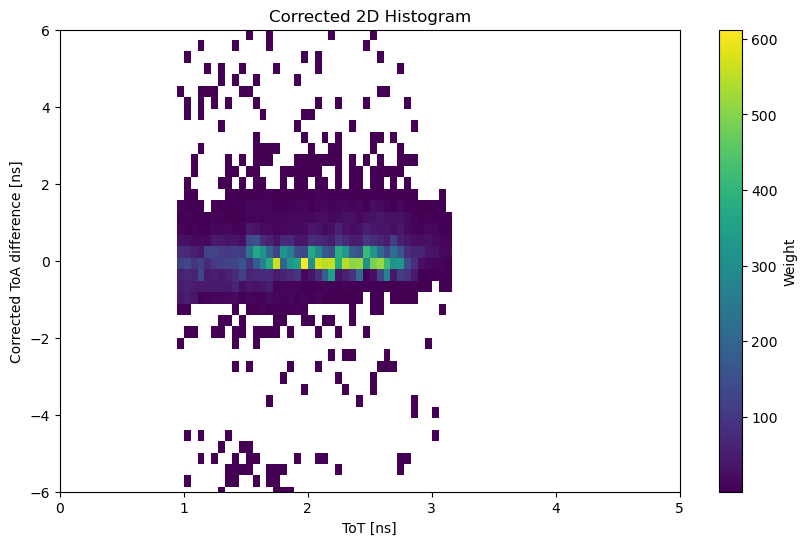

Original event count: 28567.0
Corrected event count: 25849.0


In [95]:
corrected_w = np.zeros_like(w_sliced)
ToT_valid_centers = ToT_org 
toa_diff_means = toa_diff_org 
toa_diff_errors = toa_diff_err 

corrected_ToA_values = []
for i in range(len(ToT_edges) - 1):
    for j in range(len(ToA_edges_sliced) - 1):
        if w_sliced[i, j] > 0:
            ToT_value = (ToT_edges[i] + ToT_edges[i + 1]) / 2
            if fit_range_min <= ToT_value <= fit_range_max:  
                ToA_value = (ToA_edges_sliced[j] + ToA_edges_sliced[j + 1]) / 2
                corrected_ToA_value = ToA_value - predict_fit_value(ToT_value)
                corrected_ToA_values.append(corrected_ToA_value)

corrected_ToA_values = np.array(corrected_ToA_values)
corrected_ToA_min = corrected_ToA_values.min()
corrected_ToA_max = corrected_ToA_values.max()
ToA_edges_corrected = np.linspace(corrected_ToA_min, corrected_ToA_max, len(ToA_edges_sliced))

corrected_w = np.zeros_like(w_sliced)
for i in range(len(ToT_edges) - 1):
    for j in range(len(ToA_edges_sliced) - 1):
        if w_sliced[i, j] > 0:
            ToT_value = (ToT_edges[i] + ToT_edges[i + 1]) / 2
            if fit_range_min <= ToT_value <= fit_range_max:  
                ToA_value = (ToA_edges_sliced[j] + ToA_edges_sliced[j + 1]) / 2
                corrected_ToA_value = ToA_value - predict_fit_value(ToT_value)
                
                if corrected_ToA_min <= corrected_ToA_value <= corrected_ToA_max:
                    corrected_j = np.digitize(corrected_ToA_value, ToA_edges_corrected) - 1
                    corrected_j = min(max(corrected_j, 0), len(ToA_edges_corrected) - 2)
                    corrected_w[i, corrected_j] += w_sliced[i, j]

ToT_centers = (ToT_edges[:-1] + ToT_edges[1:]) / 2
ToA_centers_corrected = (ToA_edges_corrected[:-1] + ToA_edges_corrected[1:]) / 2

plt.figure(figsize=(10, 6))
plt.pcolormesh(ToT_centers, ToA_centers_corrected, corrected_w.T, shading='auto', cmap=cmap, vmin=1)
plt.colorbar(label='Weight')
plt.xlabel('ToT [ns]')
plt.ylabel('Corrected ToA difference [ns]')
plt.ylim(-6, 6)
plt.title('Corrected 2D Histogram')
plt.show()

original_event_count = np.sum(w_sliced)
corrected_event_count = np.sum(corrected_w)

print(f"Original event count: {original_event_count}")
print(f"Corrected event count: {corrected_event_count}")


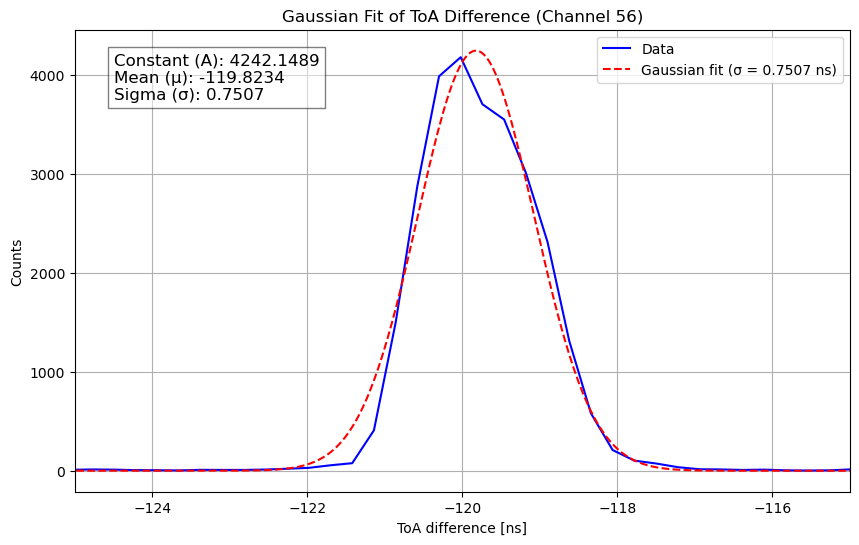

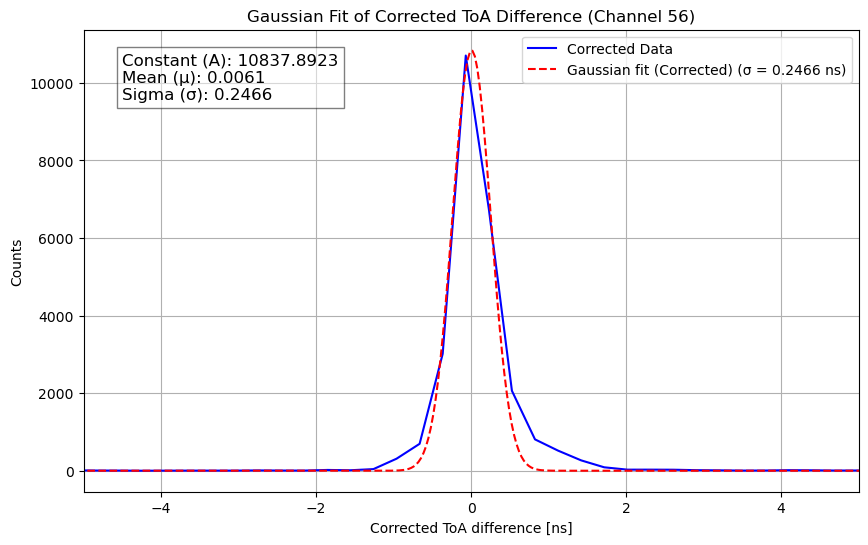

In [96]:
ToA_diff = (ToA_edges_sliced[:-1] + ToA_edges_sliced[1:]) / 2
ToA_hist = np.sum(w_sliced, axis=0)
initial_params = [ToA_hist.max(), ToA_diff[np.argmax(ToA_hist)], 1]
popt, pcov = curve_fit(gaussian, ToA_diff, ToA_hist, p0=initial_params, maxfev=1000000)
x_smooth = np.linspace(ToA_diff.min(), ToA_diff.max(), 1000)

# Plot Gaussian fit with limited x range (-125 to -115) for original data
plt.figure(figsize=(10, 6))
plt.plot(ToA_diff, ToA_hist, 'b-', label='Data')
plt.plot(x_smooth, gaussian(x_smooth, *popt), 'r--', label=f'Gaussian fit (σ = {popt[2]:.4f} ns)')
plt.xlim(-125, -115)  # Set x-axis range to -125 to -115
plt.xlabel('ToA difference [ns]')
plt.ylabel('Counts')
plt.title(f'Gaussian Fit of ToA Difference (Channel {channel})')

# Adding Gaussian fit parameters to the left top corner
textstr = f'Constant (A): {popt[0]:.4f}\nMean (µ): {popt[1]:.4f}\nSigma (σ): {popt[2]:.4f}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.savefig('result_original_limited_range.png')
plt.show()

# Corrected Gaussian fit for ToA difference
ToA_diff_corrected = (ToA_edges_corrected[:-1] + ToA_edges_corrected[1:]) / 2
ToA_hist_corrected = np.sum(corrected_w, axis=0)
initial_params_corrected = [ToA_hist_corrected.max(), ToA_diff_corrected[np.argmax(ToA_hist_corrected)], 1]
popt_corrected, pcov_corrected = curve_fit(gaussian, ToA_diff_corrected, ToA_hist_corrected, p0=initial_params_corrected, maxfev=1000000)
x_smooth_corrected = np.linspace(ToA_diff_corrected.min(), ToA_diff_corrected.max(), 1000)

# Plot Gaussian fit with limited x range (-5 to 5) for corrected data
plt.figure(figsize=(10, 6))
plt.plot(ToA_diff_corrected, ToA_hist_corrected, 'b-', label='Corrected Data')
plt.plot(x_smooth_corrected, gaussian(x_smooth_corrected, *popt_corrected), 'r--', label=f'Gaussian fit (Corrected) (σ = {popt_corrected[2]:.4f} ns)')
plt.xlim(-5, 5)  # Set x-axis range to -5 to +5
plt.xlabel('Corrected ToA difference [ns]')
plt.ylabel('Counts')
plt.title(f'Gaussian Fit of Corrected ToA Difference (Channel {channel})')

# Adding Gaussian fit parameters to the left top corner
textstr_corrected = f'Constant (A): {popt_corrected[0]:.4f}\nMean (µ): {popt_corrected[1]:.4f}\nSigma (σ): {popt_corrected[2]:.4f}'
plt.text(0.05, 0.95, textstr_corrected, transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.5))

plt.legend()
plt.grid(True)
plt.savefig('result_corrected_limited_range.png')
plt.show()

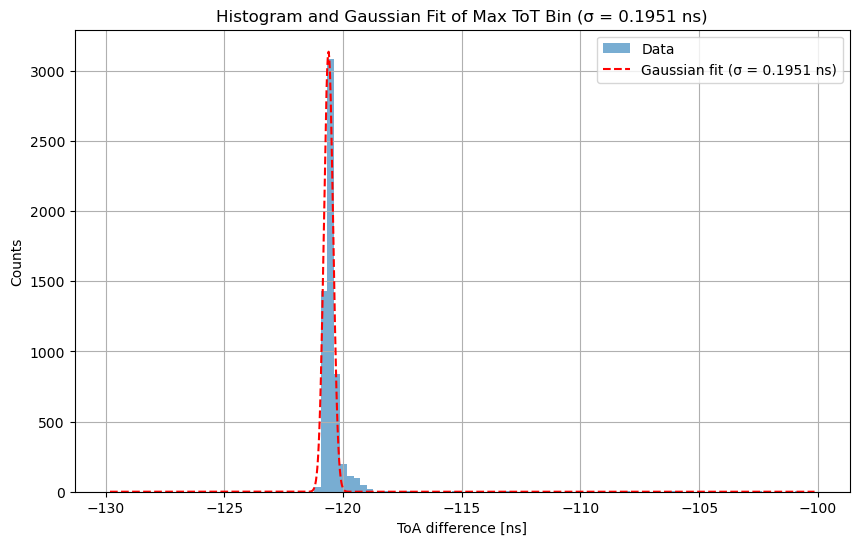

In [88]:
def plot_max_bin_histogram(w_sliced, ToT_edges, ToA_edges_sliced):
    num_bins = 40
    ToT_bin_edges = np.linspace(ToT_edges[0], ToT_edges[-1], num_bins + 1)
    ToT_bin_centers = (ToT_bin_edges[:-1] + ToT_bin_edges[1:]) / 2

    max_bin_index = np.argmax([np.sum(w_sliced[(ToT_edges[:-1] >= ToT_bin_edges[i]) & (ToT_edges[:-1] < ToT_bin_edges[i + 1]), :]) for i in range(num_bins)])

    bin_mask = (ToT_edges[:-1] >= ToT_bin_edges[max_bin_index]) & (ToT_edges[:-1] < ToT_bin_edges[max_bin_index + 1])
    bin_weights = w_sliced[bin_mask, :].sum(axis=0)

    bin_centers = (ToA_edges_sliced[:-1] + ToA_edges_sliced[1:]) / 2

    popt_gauss, _ = curve_fit(gaussian, bin_centers, bin_weights, p0=[np.max(bin_weights), bin_centers[np.argmax(bin_weights)], 1], maxfev=10000000)
    sigma = popt_gauss[2]

    plt.figure(figsize=(10, 6))
    plt.hist(bin_centers, bins=len(bin_centers), weights=bin_weights, alpha=0.6, label='Data')
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
    plt.plot(x_smooth, gaussian(x_smooth, *popt_gauss), 'r--', label=f'Gaussian fit (σ = {sigma:.4f} ns)')
    
    plt.xlabel('ToA difference [ns]')
    plt.ylabel('Counts')
    plt.title(f'Histogram and Gaussian Fit of Max ToT Bin (σ = {sigma:.4f} ns)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_max_bin_histogram(w_sliced, ToT_edges, ToA_edges_sliced)


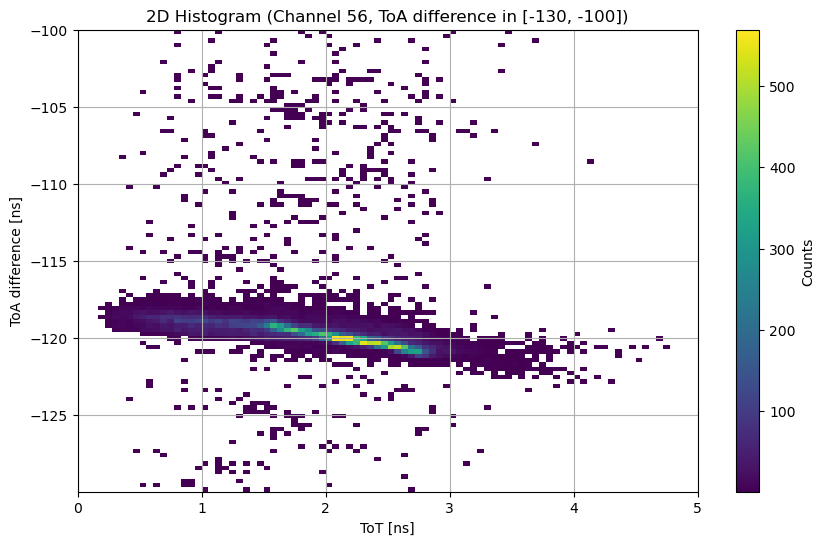

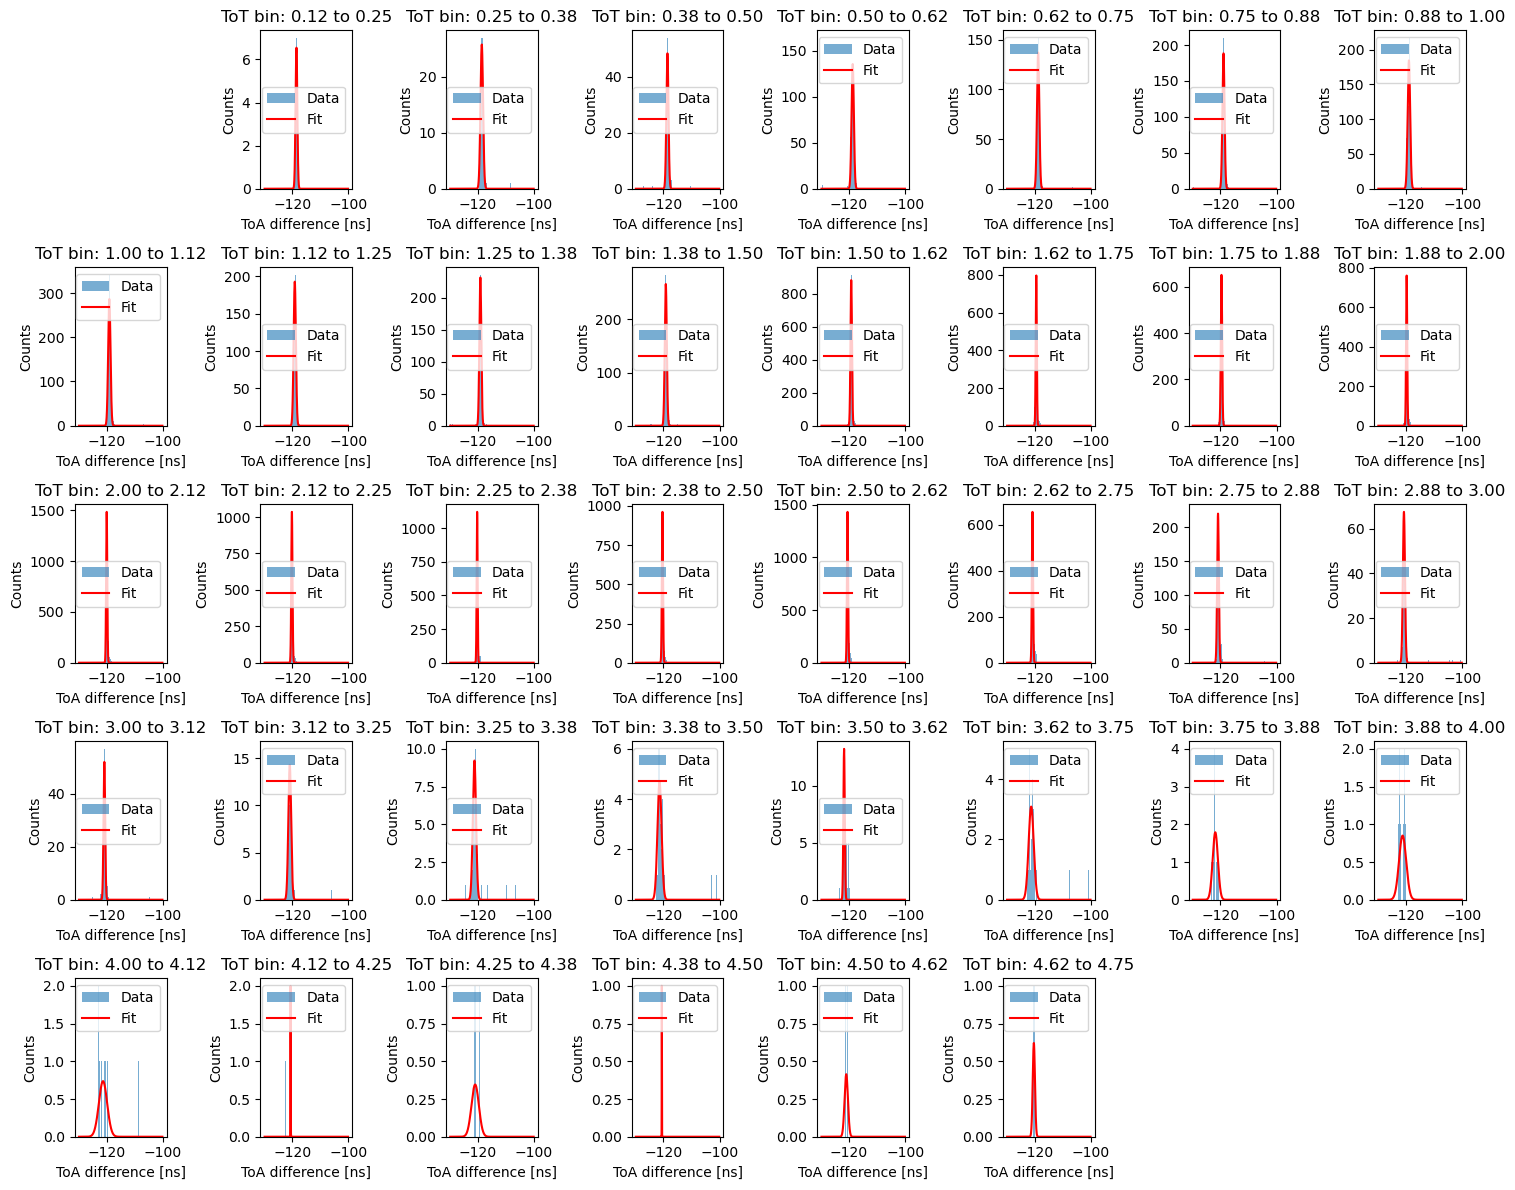

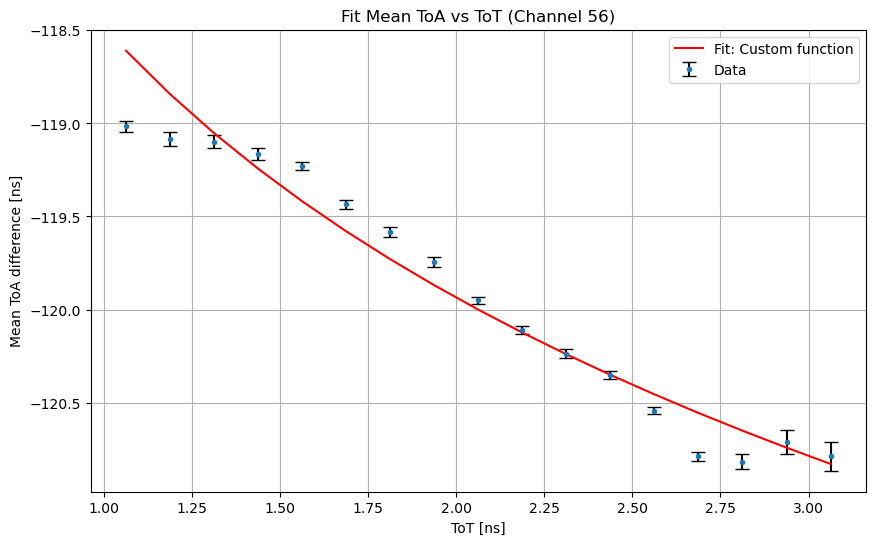

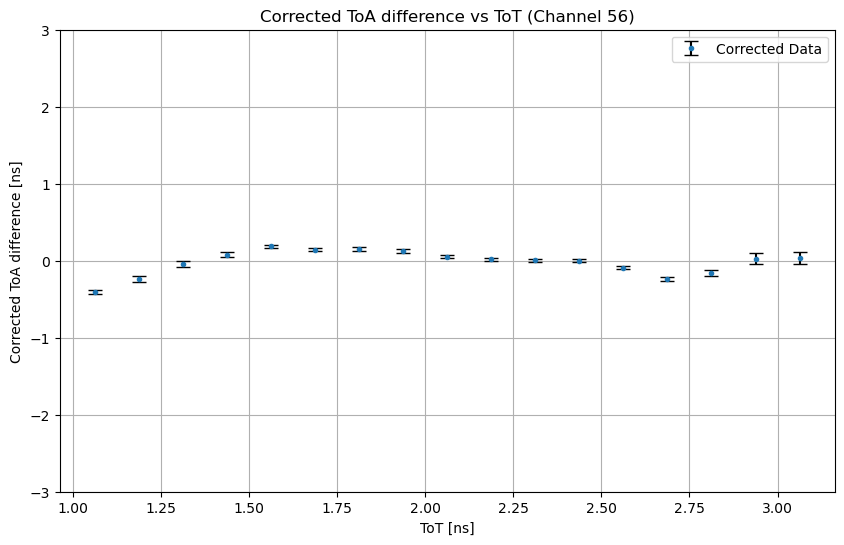

Predicted fit value for ToT = 3: -120.78650644562549
Fitted parameters:
a = 16.956257873474144
b = -11331.199410862333
c = 0.0001851195704511791
d = -11449.681673084351


In [93]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def import_data(file_path, hist_name):
    root_file = uproot.open(file_path)
    hist = root_file[hist_name]
    w, x_edges, y_edges = hist.to_numpy()
    return w, x_edges, y_edges 

file_path = 'time_difference_plots_tref_ch7_fullTDC_LAPPD_bottom_run0419.root'
channel = 56
hist_name_template = 'ToA_ToT_intime_ch{0};1'
hist_name = hist_name_template.format(channel)

w, ToT_edges, ToA_edges = import_data(file_path, hist_name)

y_min = -130
y_max = -100

y_indices = np.where((ToA_edges >= y_min) & (ToA_edges <= y_max))[0]

if ToA_edges[y_indices[-1]] > y_max:
    y_indices = y_indices[:-1]

w_sliced = w[:, y_indices[:-1]]
ToA_edges_sliced = ToA_edges[y_indices]

cmap = plt.cm.viridis
cmap.set_under(color='white')

plt.figure(figsize=(10, 6))
plt.pcolormesh(ToT_edges, ToA_edges_sliced, w_sliced.T, shading='auto', cmap=cmap, vmin=1)
plt.xlabel('ToT [ns]')
plt.ylabel('ToA difference [ns]')
plt.title(f'2D Histogram (Channel {channel}, ToA difference in [{y_min}, {y_max}])')
plt.colorbar(label='Counts')
plt.grid(True)
plt.savefig('data.png')
plt.show()

def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))

# Create 20 bins for ToT
num_bins = 40
ToT_bin_edges = np.linspace(ToT_edges[0], ToT_edges[-1], num_bins + 1)
ToT_bin_centers = (ToT_bin_edges[:-1] + ToT_bin_edges[1:]) / 2

toa_diff_means = []
toa_diff_errors = []
ToT_valid_centers = []

plt.figure(figsize=(15, 12))
for i in range(num_bins):
    bin_min = ToT_bin_edges[i]
    bin_max = ToT_bin_edges[i + 1]
    
    bin_mask = (ToT_edges[:-1] >= bin_min) & (ToT_edges[:-1] < bin_max)
    
    if np.any(bin_mask):
        bin_weights = w_sliced[bin_mask, :].sum(axis=0)
    else:
        bin_weights = np.zeros_like(ToA_edges_sliced[:-1])
    
    if bin_weights.sum() > 0:  # Only process bins with data

        bin_centers = (ToA_edges_sliced[:-1] + ToA_edges_sliced[1:]) / 2
        popt, _ = curve_fit(gaussian, bin_centers, bin_weights, p0=[np.max(bin_weights), bin_centers[np.argmax(bin_weights)], 1], maxfev=1000000)
        
        amp, mean, sigma = popt
        N = bin_weights.sum()
        error = np.sqrt(N) / N
        
        ToT_valid_centers.append(ToT_bin_centers[i])
        toa_diff_means.append(mean)
        toa_diff_errors.append(error)
        
        # Generate smooth x values for the Gaussian fit
        x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 1000)
        
        # Plot the histogram and Gaussian fit
        plt.subplot(5, 8, i + 1)
        plt.hist(bin_centers, bins=len(bin_centers), weights=bin_weights, alpha=0.6, label='Data')
        plt.plot(x_smooth, gaussian(x_smooth, *popt), 'r-', label='Fit')
        plt.xlabel('ToA difference [ns]')
        plt.ylabel('Counts')
        plt.title(f'ToT bin: {bin_min:.2f} to {bin_max:.2f}')
        plt.legend()
        
plt.tight_layout()
plt.show()

ToT_valid_centers = np.array(ToT_valid_centers)
toa_diff_means = np.array(toa_diff_means)
toa_diff_errors = np.array(toa_diff_errors)

ToT_org = ToT_valid_centers
toa_diff_org = toa_diff_means
toa_diff_err = toa_diff_errors

max_bin_index = np.argmax([np.sum(w_sliced[(ToT_edges[:-1] >= ToT_bin_edges[i]) & (ToT_edges[:-1] < ToT_bin_edges[i + 1]), :]) for i in range(num_bins)])
max_bin_center = ToT_bin_centers[max_bin_index]

fit_range_min = max_bin_center - 1.1
fit_range_max = max_bin_center + 1.1

mask = (ToT_valid_centers >= fit_range_min) & (ToT_valid_centers <= fit_range_max)
ToT_valid_centers = ToT_valid_centers[mask]
toa_diff_means = toa_diff_means[mask]
toa_diff_errors = toa_diff_errors[mask]

def custom_fit_function(ToT, a, b, c, d):
    ToA = np.zeros_like(ToT)
    
    a = max(a, 1e-6)
    c = max(c, 1e-6)
    
    # When ToT >= a
    ToA[ToT >= a] = -b / (a**c) * (1 + c) + (ToT[ToT >= a] * b * c) / (a**(c + 1)) + d
    # When ToT < a
    ToA[ToT < a] = -b / (ToT[ToT < a]**c) + d
    
    return ToA

# Add bounds to ensure a and c are positive
popt, pcov = curve_fit(custom_fit_function, ToT_valid_centers, toa_diff_means, sigma=toa_diff_errors, 
                       bounds=([0, -np.inf, 0, -np.inf], [np.inf, np.inf, np.inf, np.inf]), maxfev=1000000)



a, b, c, d = popt

fit_values = custom_fit_function(ToT_valid_centers, a, b, c, d)

# Plot the fit
plt.figure(figsize=(10, 6))
plt.errorbar(ToT_valid_centers, toa_diff_means, yerr=toa_diff_errors, fmt='o', markersize=3, label='Data', capsize=5, capthick=1, ecolor='black')
plt.plot(ToT_valid_centers, fit_values, label='Fit: Custom function', color='red')
plt.xlabel('ToT [ns]')
plt.ylabel('Mean ToA difference [ns]')
plt.title(f'Fit Mean ToA vs ToT (Channel {channel})')
plt.legend()
plt.grid(True)
plt.savefig('fit_custom_function.png')
plt.show()

corrected_ToA_diff = toa_diff_means - fit_values

plt.figure(figsize=(10, 6))
plt.errorbar(ToT_valid_centers, corrected_ToA_diff, yerr=toa_diff_errors, fmt='o', markersize=3, label='Corrected Data', capsize=5, capthick=1, ecolor='black')
plt.xlabel('ToT [ns]')
plt.ylabel('Corrected ToA difference [ns]')
plt.title(f'Corrected ToA difference vs ToT (Channel {channel})')
plt.ylim(-3, 3)
plt.legend()
plt.grid(True)
plt.savefig('corrected_custom_function.png')
plt.show()

def predict_fit_value(tot_value):
    if tot_value >= a:
        return -b / (a**c) * (1 + c) + (tot_value * b * c) / (a**(c + 1)) + d
    else:
        return -b / (tot_value**c) + d

# Example usage of prediction function
example_tot_value = 3
predicted_fit_value = predict_fit_value(example_tot_value)
print(f"Predicted fit value for ToT = {example_tot_value}: {predicted_fit_value}")

print(f"Fitted parameters:\na = {a}\nb = {b}\nc = {c}\nd = {d}")
